# Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium 
import requests

# Neighbourhood of Barcelona

### Data

In [2]:
# Load neighbourhood csv
neigh = pd.read_csv('csv/Distritos BCN.csv')

# Rename columns
neigh.rename(columns={'NOM_DISTRICTE':'Borough','NOM_BARRI': 'Neighbourhood'}, inplace=True)

# Drop columns
neigh.drop(['CODI_DISTRICTE','CODI_BARRI'],axis=1,inplace=True)

# Print
print('Number of Neighbourhoods:',neigh.index.shape)

neigh.head()

Number of Neighbourhoods: (73,)


,Borough,Neighbourhood
0,Ciutat Vella,el Raval
1,Ciutat Vella,el Barri Gòtic
2,Ciutat Vella,la Barceloneta
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
4,Eixample,el Fort Pienc


**Knowing the ten boroughs of Barcelona:**

In [3]:
neigh.groupby(['Borough']).count().reset_index()

,Borough,Neighbourhood
0,Ciutat Vella,4
1,Eixample,6
2,Gràcia,5
3,Horta-Guinardó,11
4,Les Corts,3
5,Nou Barris,13
6,Sant Andreu,7
7,Sant Martí,10
8,Sants-Montjuïc,8
9,Sarrià-Sant Gervasi,6


<img src="ims/bcnmap.png" width=300 align="center"  > 

# Coordinates of neighbourhoods

### Data

In [4]:
# Load bus stations of the neighbourhoods csv
coord_ = pd.read_csv('csv/Puntos_barrio.csv')

coord_.head()

,CODI_CAPA,CAPA_GENERICA,NOM_CAPA,ED50_COORD_X,ED50_COORD_Y,ETRS89_COORD_X,ETRS89_COORD_Y,LONGITUD,LATITUD,EQUIPAMENT,DISTRICTE,BARRI,NOM_DISTRICTE,NOM_BARRI,ADRECA,TELEFON
0,K014,Transports i serveis relacionats,Autobusos diürns,428791.068,4585039.461,428699.152,4584838.501,2.146875,41.411935,BUS -87--,6.0,28.0,Gràcia,Vallcarca i els Penitents,NaN,NaN
1,K016,Transports i serveis relacionats,Autobus a l'aeroport,430766.260,4582292.013,430674.325,4582091.078,2.170821,41.387362,AEROBUS -A2--,2.0,7.0,Eixample,la Dreta de l'Eixample,NaN,NaN
2,K014,Transports i serveis relacionats,Autobusos diürns,429170.590,4580920.343,429078.670,4580719.421,2.151898,41.374869,BUS -L70--,3.0,11.0,Sants-Montjuïc,el Poble-sec,NaN,NaN
3,K015,Transports i serveis relacionats,Autobusos nocturns,431376.348,4581004.947,431284.407,4580804.024,2.178263,41.375823,NITBUS -N0--,1.0,2.0,Ciutat Vella,el Barri Gòtic,NaN,NaN
4,K015,Transports i serveis relacionats,Autobusos nocturns,428566.477,4581967.626,428474.562,4581766.695,2.144551,41.384248,NITBUS -N0--,2.0,9.0,Eixample,la Nova Esquerra de l'Eixample,NaN,NaN


### Transforming data

In [5]:
# Drop the NaN values in NOM_BARRI column
coord = coord_.dropna(subset=['NOM_BARRI'])

# Group by neighbourhood and show the mean Latitud and Longitud
coord = coord.groupby('NOM_BARRI')[['LATITUD','LONGITUD']].mean().reset_index()

# Rename column
coord.rename(columns={'NOM_BARRI':'Neighbourhood','LATITUD':'Latitud','LONGITUD':'Longitud'},inplace=True)

# Print
print('Size before:',coord_.shape)
print('Size after:', coord.shape)

coord.head()

Size before: (3156, 16)
Size after: (73, 3)


,Neighbourhood,Latitud,Longitud
0,Baró de Viver,41.446030,2.199706
1,Can Baró,41.415980,2.163248
2,Can Peguera,41.435088,2.166949
3,Canyelles,41.443092,2.166052
4,Ciutat Meridiana,41.461113,2.175853


### Data Visualization

In [6]:
latitude_bcn = 41.38879
longitud_bcn = 2.15899

bcn_map = folium.Map(location=[latitude_bcn,longitud_bcn],zoom_start=12,tiles='cartodbpositron')

for lat, lng, in zip(coord['Latitud'], coord['Longitud']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='darkblue',
        fill=True,
        fill_color='darkblue',
        fill_opacity=0.5).add_to(bcn_map)
        
        
bcn_map 

# Apartment rental 

### Data

In [7]:
# Load renta apartment data
renta = pd.read_csv('csv/Lloguer_preu_trim.csv')

renta.head()

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2018,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),792.74
1,2018,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),998.40
2,2018,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),870.84
3,2018,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),923.44
4,2018,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),910.53


### Transforming Data

In [8]:
# Delete rows that we don't need
bcn_rent = renta[renta.Lloguer_mitja != 'Lloguer mitjà per superfície (Euros/m2 mes)']

# Fill NaN values with average price from each corresponding neighborhood
bcn_rent['Preu']=bcn_rent['Preu'].fillna(bcn_rent.groupby('Nom_Districte')['Preu'].transform('mean'))

# Get the average rent of the apartments
bcn_rent = bcn_rent.groupby('Nom_Barri')['Preu'].mean().reset_index()

# Rename columns
bcn_rent.rename(columns={'Nom_Barri':'Neighbourhood','Preu':'Aveg_Rent'},inplace=True)

# Uniform names
bcn_rent.at[42,'Neighbourhood'] = "el Poble-sec"

# Print
print('Size before:',renta.shape)
print('Size after:', bcn_rent.shape)

bcn_rent.head()

Size before: (584, 8)
Size after: (73, 2)


<ipython-input-8-29fafba867a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcn_rent['Preu']=bcn_rent['Preu'].fillna(bcn_rent.groupby('Nom_Districte')['Preu'].transform('mean'))


,Neighbourhood,Aveg_Rent
0,Baró de Viver,716.818900
1,Can Baró,738.177500
2,Can Peguera,648.947561
3,Canyelles,716.597500
4,Ciutat Meridiana,506.965000


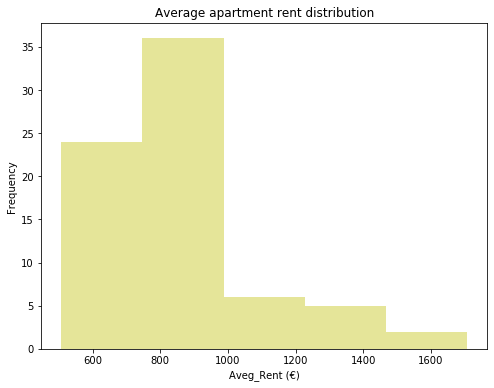

In [9]:
fig = plt.figure(figsize=(8, 6))
sns.distplot(bcn_rent['Aveg_Rent'], bins=5,kde=False,color='y')

plt.title('Average apartment rent distribution')
plt.ylabel('Frequency')
plt.xlabel('Aveg_Rent (€)')

plt.savefig('rent_hist.png')

plt.show()

# Libraries

### Data

In [10]:
lib_= pd.read_csv('csv/Bibliotecas.csv')

lib_.head()

,Any,Indicador,Equipament,Valor,Notes_Dades,Notes_Equipament,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Titularitat,TipusGeneral,TipusEquipament,Ambit,Latitud,Longitud
0,2017,Assistents_Activitats,Biblioteca Barceloneta - La Fraternitat,1007,NaN,NaN,1,Ciutat Vella,3,la Barceloneta,Consorci o fundació amb presència municipal,Biblioteques de Barcelona,Biblioteques,Lletres,41.379201,2.188854
1,2017,Assistents_Activitats,Biblioteca Francesca Bonnemaison,2732,NaN,NaN,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Consorci o fundació amb presència municipal,Biblioteques de Barcelona,Biblioteques,Lletres,41.386937,2.175790
2,2017,Assistents_Activitats,Biblioteca Gòtic - Andreu Nin,1430,NaN,NaN,1,Ciutat Vella,2,el Barri Gòtic,Consorci o fundació amb presència municipal,Biblioteques de Barcelona,Biblioteques,Lletres,41.378730,2.175979
3,2017,Assistents_Activitats,Biblioteca Sant Pau i Santa Creu,1009,NaN,NaN,1,Ciutat Vella,1,el Raval,Consorci o fundació amb presència municipal,Biblioteques de Barcelona,Biblioteques,Lletres,41.381057,2.169794
4,2017,Assistents_Activitats,Biblioteca Esquerra de l'Eixample-Agustí Cente...,4754,NaN,NaN,2,Eixample,9,la Nova Esquerra de l'Eixample,Consorci o fundació amb presència municipal,Biblioteques de Barcelona,Biblioteques,Lletres,41.386449,2.152790


### Transforming Data

In [11]:
# Only needed columns
lib = lib_[['Indicador','Equipament','Nom_Barri','Latitud','Longitud']]

# Delete rows and columns that we don't need:
lib = lib[lib.Indicador == 'Assistents_Activitats']
lib.drop(['Indicador'],axis=1,inplace=True)

# Rename columns
lib.rename(columns={'Equipament':'Library Name','Nom_Barri':'Neighbourhood'},inplace=True)

# Uniform names
lib.at[11,'Neighbourhood'] = "la Dreta de l'Eixample"
lib.at[9,'Neighbourhood'] = "la Dreta de l'Eixample"

# Print
print('Size before:',lib_.shape)
print('Size after:', lib.shape)


lib.head()

Size before: (360, 16)
Size after: (40, 4)


,Library Name,Neighbourhood,Latitud,Longitud
0,Biblioteca Barceloneta - La Fraternitat,la Barceloneta,41.379201,2.188854
1,Biblioteca Francesca Bonnemaison,"Sant Pere, Santa Caterina i la Ribera",41.386937,2.175790
2,Biblioteca Gòtic - Andreu Nin,el Barri Gòtic,41.378730,2.175979
3,Biblioteca Sant Pau i Santa Creu,el Raval,41.381057,2.169794
4,Biblioteca Esquerra de l'Eixample-Agustí Cente...,la Nova Esquerra de l'Eixample,41.386449,2.152790


### Data Visualization

In [12]:
latitude_bcn = 41.38879
longitud_bcn = 2.15899

bcn_map = folium.Map(location=[latitude_bcn,longitud_bcn],zoom_start=12,tiles='cartodbpositron')

for lat, lng, in zip(lib['Latitud'], lib['Longitud']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5).add_to(bcn_map)
        
        
bcn_map 

# Transport

### Data

In [13]:
tran_ = pd.read_csv('csv/Transporte.csv')

tran_.head()

,CODI_CAPA,CAPA_GENERICA,NOM_CAPA,ED50_COORD_X,ED50_COORD_Y,ETRS89_COORD_X,ETRS89_COORD_Y,LONGITUD,LATITUD,EQUIPAMENT,DISTRICTE,BARRI,NOM_DISTRICTE,NOM_BARRI,ADRECA,TELEFON
0,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,428480.365,4586484.614,428388.453,4586283.641,2.142987,41.424923,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",7.0,41.0,Horta-Guinardó,la Vall d'Hebron,NaN,NaN
1,K002,Transports i serveis relacionats,Ferrocarrils Generalitat (FGC),429726.943,4582853.670,429635.018,4582652.730,2.158326,41.392331,FGC - PROVENÇA (C. de Provença)-,2.0,8.0,Eixample,l'Antiga Esquerra de l'Eixample,NaN,NaN
2,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,426477.889,4583649.008,426385.994,4583448.062,2.119370,41.399203,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,5.0,23.0,Sarrià-Sant Gervasi,Sarrià,NaN,NaN
3,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,427818.595,4583478.761,427726.688,4583277.816,2.135427,41.397791,FGC (L6) - LA BONANOVA-,5.0,26.0,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,NaN,NaN
4,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,432051.444,4589400.176,431959.500,4589199.175,2.185391,41.451492,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,8.0,53.0,Nou Barris,la Trinitat Nova,NaN,NaN


### Transforming Data

In [14]:
# Delete rows that we don't need
tran = tran_.dropna(subset=['NOM_BARRI'])

# Only needed columns
tran = tran[['EQUIPAMENT','NOM_BARRI','LATITUD','LONGITUD']]

# Rename columns
tran.rename(columns={'EQUIPAMENT':'Point','NOM_BARRI':'Neighbourhood','LATITUD':'Latitud','LONGITUD':'Longitud'},inplace=True)

# Print
print('Size before:',tran_.shape)
print('Size after:', tran.shape)

tran.head()

Size before: (651, 16)
Size after: (487, 4)


,Point,Neighbourhood,Latitud,Longitud
0,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",la Vall d'Hebron,41.424923,2.142987
1,FGC - PROVENÇA (C. de Provença)-,l'Antiga Esquerra de l'Eixample,41.392331,2.158326
2,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,Sarrià,41.399203,2.119370
3,FGC (L6) - LA BONANOVA-,Sant Gervasi - Galvany,41.397791,2.135427
4,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,la Trinitat Nova,41.451492,2.185391


### Data Visualization

In [15]:
latitude_bcn = 41.38879
longitud_bcn = 2.15899

bcn_map = folium.Map(location=[latitude_bcn,longitud_bcn],zoom_start=12,tiles='cartodbpositron')

for lat, lng, in zip(tran['Latitud'], tran['Longitud']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='darkgreen',
        fill=True,
        fill_color='darkgreen',
        fill_opacity=0.5).add_to(bcn_map)
        

bcn_map 

# Foursquare

### Load Credentials

In [16]:
CLIENT_ID = 'OVDNTMRW1PFQQFY1RBLTINBPQTFDX4SJ3QNIZWOKH2WSYW2E' # your Foursquare ID
CLIENT_SECRET = '2O2ROHPQYSTRJYCZ11QNK00IVQG5XEMJ3ERXO5E2MGLU2V3E' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OVDNTMRW1PFQQFY1RBLTINBPQTFDX4SJ3QNIZWOKH2WSYW2E
CLIENT_SECRET:2O2ROHPQYSTRJYCZ11QNK00IVQG5XEMJ3ERXO5E2MGLU2V3E


### Venues from all neighborhoods

In [17]:
LIMIT = 100

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
venues_df = getNearbyVenues(names=coord['Neighbourhood'],
                                   latitudes=coord['Latitud'],
                                   longitudes=coord['Longitud'])

In [20]:
print('Dataframe size:',venues_df.shape)
venues_df.head()

Dataframe size: (3619, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Baró de Viver,41.44603,2.199706,Apple La Maquinista,41.440802,2.198427,Electronics Store
1,Baró de Viver,41.44603,2.199706,Pasteleria Buenavista,41.442172,2.199977,Dessert Shop
2,Baró de Viver,41.44603,2.199706,Ibericus,41.441505,2.197812,Food
3,Baró de Viver,41.44603,2.199706,A Loja do Gato Preto,41.441689,2.197742,Furniture / Home Store
4,Baró de Viver,41.44603,2.199706,Restaurant Enriqueta,41.445684,2.206801,Spanish Restaurant


### Exploring Data

In [21]:
# All venues for each Neighbourhood
venues_df.groupby('Neighbourhood')['Venue'].count().reset_index()

,Neighbourhood,Venue
0,Baró de Viver,23
1,Can Baró,31
2,Can Peguera,33
3,Canyelles,15
4,Ciutat Meridiana,7
...,...,...
68,la Vila Olímpica del Poblenou,100
69,la Vila de Gràcia,100
70,les Corts,71
71,les Roquetes,9


### Data Visualization

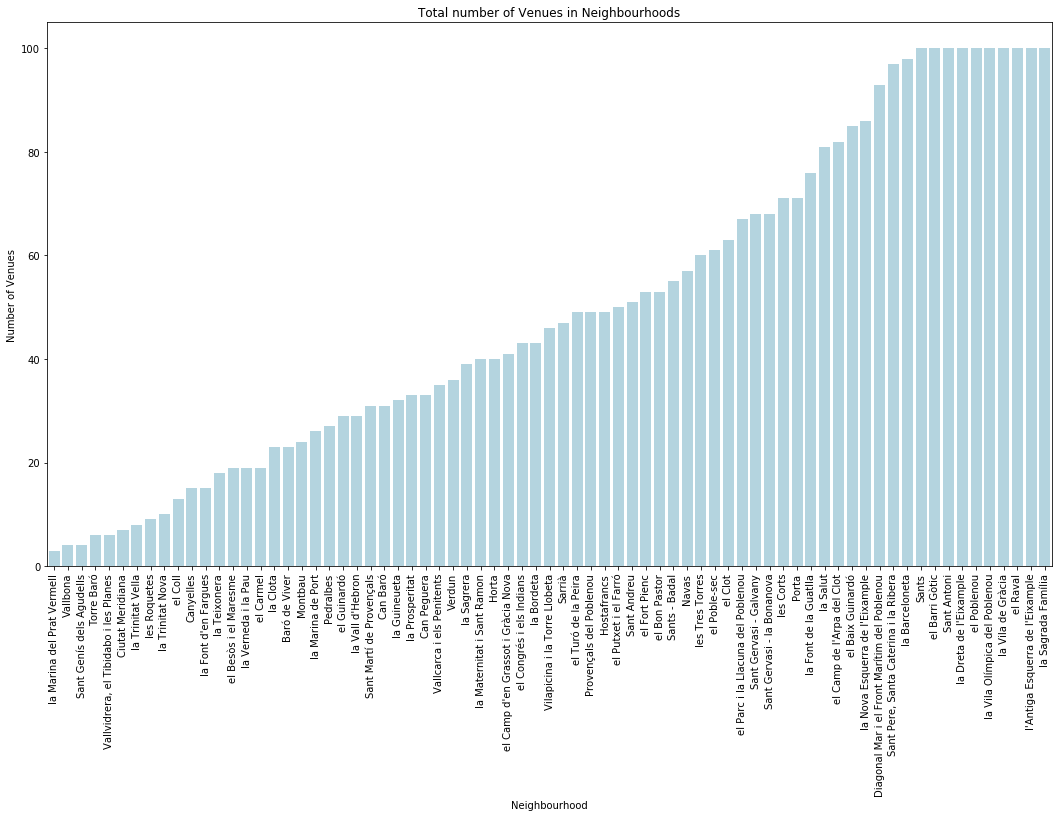

In [22]:
# Define new dataframe
df_viz = venues_df.groupby('Neighbourhood').count().sort_values(by=['Venue'])

# Size of figure
fig = plt.figure(figsize=(18, 10))

# Plot using seaborn
ax=sns.barplot(x=df_viz.index,y=df_viz['Venue'],color='lightblue')


plt.title('Total number of Venues in Neighbourhoods')
plt.xticks(rotation=90)
plt.ylabel('Number of Venues')

plt.savefig('venues_neighbourhood.png')

plt.show()

In [23]:
# Uniques categories
print('There are {} uniques categories'.format(len(venues_df['Venue Category'].unique())))

There are 297 uniques categories


## Preparing Categorical Data: venues

### One hot encoder

In [24]:
# one hot encoding
venues_df_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_df_onehot['Neighbourhood'] = venues_df['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_df_onehot.columns[-1]] + list(venues_df_onehot.columns[:-1])
venues_df_onehot = venues_df_onehot[fixed_columns]

print('Dataframe size:',venues_df_onehot.shape)
venues_df_onehot.head()

Dataframe size: (3619, 298)


,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Baró de Viver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baró de Viver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baró de Viver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Baró de Viver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baró de Viver,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group by Neighbourhood

In [25]:
bcn_venues = venues_df_onehot.groupby('Neighbourhood').mean().reset_index()
print('Dataframe size:',bcn_venues.shape)
bcn_venues.head()

Dataframe size: (73, 298)


,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Baró de Viver,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Can Baró,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Can Peguera,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Canyelles,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ciutat Meridiana,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 10 most common venues

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bcn_venues_10 = pd.DataFrame(columns=columns)
bcn_venues_10['Neighbourhood'] = bcn_venues['Neighbourhood']

for ind in np.arange(bcn_venues.shape[0]):
    bcn_venues_10.iloc[ind, 1:] = return_most_common_venues(bcn_venues.iloc[ind, :], num_top_venues)

bcn_venues_10.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baró de Viver,Spanish Restaurant,Clothing Store,Plaza,Asian Restaurant,Food,Supermarket,Furniture / Home Store,Metro Station,Bookstore,Mediterranean Restaurant
1,Can Baró,Spanish Restaurant,Tapas Restaurant,Grocery Store,Plaza,Chinese Restaurant,Bar,Restaurant,Scenic Lookout,Bookstore,Cambodian Restaurant
2,Can Peguera,Grocery Store,Pizza Place,Supermarket,Tapas Restaurant,Breakfast Spot,Seafood Restaurant,Park,Plaza,Sports Club,Café
3,Canyelles,Soccer Field,Café,Market,Grocery Store,Mediterranean Restaurant,Skate Park,Metro Station,Tapas Restaurant,Food Court,Plaza
4,Ciutat Meridiana,Supermarket,Plaza,Train Station,Grocery Store,Mediterranean Restaurant,Metro Station,Park,Food & Drink Shop,Food,Flower Shop


# Final Dataframe

I combine the 4 dataframes into a **master table** called 'result'.

| Data              | Name          | Type           | Approach        | 
|-------------------|---------------|----------------|-----------------|
| Rent Apartment    | bcn_rent      | Float          | -               | 
| Libraries         | bcn_lib       | Categorical    | OneHotEncoding  | 
| Transport         | bcn_tran      | Categorical    | OneHotEncoding  | 
| Venues            | bcn_venues    | Categorical    | OneHotEncoding  | 

## Preparing Categorical Data: libraries and transport

### Libraries: bcn_lib

In [27]:
print('There are {} uniques categories'.format(len(lib['Library Name'].unique())))

There are 40 uniques categories


In [28]:
# one hot encoding
lib_onehot = pd.get_dummies(lib[['Library Name']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lib_onehot['Neighbourhood'] = lib['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [lib_onehot.columns[-1]] + list(lib_onehot.columns[:-1])
lib_onehot = lib_onehot[fixed_columns]

# Group by Neighbourhood
bcn_lib=lib_onehot.groupby('Neighbourhood').mean().reset_index()
print('Dataframe size:',bcn_lib.shape)
bcn_lib.head()

Dataframe size: (37, 41)


,Neighbourhood,Biblioteca Barceloneta - La Fraternitat,Biblioteca Bon Pastor,Biblioteca Camp de l'Arpa - Caterina Albert,Biblioteca Can Rosés,Biblioteca Canyelles,Biblioteca Clarà,Biblioteca Collserola - Josep Miracle,Biblioteca El Carmel - Juan Marsé,Biblioteca El Clot - Josep Benet,...,Biblioteca Sant Martí de Provençals,Biblioteca Sant Pau i Santa Creu,Biblioteca Sofia Barat,Biblioteca Trinitat Vella - J. Barbero,Biblioteca Vallcarca i els Penitents,Biblioteca Vapor Vell,Biblioteca Vila de Gràcia,Biblioteca Vilapicina i la Torre Llobeta,Biblioteca Xavier Benguerel,Biblioteca Zona Nord
0,Canyelles,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Horta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Montbau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sant Andreu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sant Antoni,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transport: bcn_tran

In [29]:
# Uniques categories
print('There are {} uniques categories'.format(len(tran['Point'].unique())))

There are 425 uniques categories


In [30]:
# one hot encoding
tran_onehot = pd.get_dummies(tran[['Point']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tran_onehot['Neighbourhood'] = tran['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [tran_onehot.columns[-1]] + list(tran_onehot.columns[:-1])
tran_onehot = tran_onehot[fixed_columns]

bcn_tran = tran_onehot.groupby('Neighbourhood').mean().reset_index()
print('Dataframe size:',bcn_tran.shape)
bcn_tran.head()

Dataframe size: (63, 426)


,Neighbourhood,Estació Marítima Grimaldi Lines,FGC (L6) - LA BONANOVA-,FGC (L6) - LES TRES TORRES-,FGC (L6) - MUNTANER-,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'Orleans)-,FGC (L6) - REINA ELISENDA (Sortida J. V. Foix)-,FGC (L6) - REINA ELISENDA-,FGC (L6) - SANT GERVASI-,FGC (L6) - SARRIÀ-,...,Terminal Marítima E *Creuers,Terminal Marítima Maremàgnum *Creuers,Terminal Marítima Sant Bertran *Ferris,Transbordador del Port - Jaume I-,Transbordador del Port - Miramar-,Transbordador del Port - Sant Sebastià-,Tren AEROPORT - CLOT-,Tren AEROPORT - PASSEIG DE GRÀCIA-,Tren AEROPORT - SANT ANDREU COMTAL-,Tren AEROPORT - SANTS ESTACIÓ-
0,Canyelles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ciutat Meridiana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Diagonal Mar i el Front Marítim del Poblenou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Horta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hostafrancs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Concatenate Dataframe

In [31]:
# Change index into 'Neighbourhood' column
a=bcn_rent.set_index('Neighbourhood')
b=bcn_lib.set_index('Neighbourhood')
c=bcn_tran.set_index('Neighbourhood')
d=bcn_venues.set_index('Neighbourhood')

# Concatenate four dataframe 
result = pd.concat([a,b,c,d],axis=1,sort=False)

# Fill NaN
result = result.fillna(0)

# Print
print('The size of Master table is:',result.shape)
result.head()

The size of Master table is: (73, 763)


,Aveg_Rent,Biblioteca Barceloneta - La Fraternitat,Biblioteca Bon Pastor,Biblioteca Camp de l'Arpa - Caterina Albert,Biblioteca Can Rosés,Biblioteca Canyelles,Biblioteca Clarà,Biblioteca Collserola - Josep Miracle,Biblioteca El Carmel - Juan Marsé,Biblioteca El Clot - Josep Benet,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
Baró de Viver,716.818900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Can Baró,738.177500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Can Peguera,648.947561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Canyelles,716.597500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ciutat Meridiana,506.965000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Machine Learning: Clustering

In [32]:
from sklearn.cluster import KMeans

### Elbow method

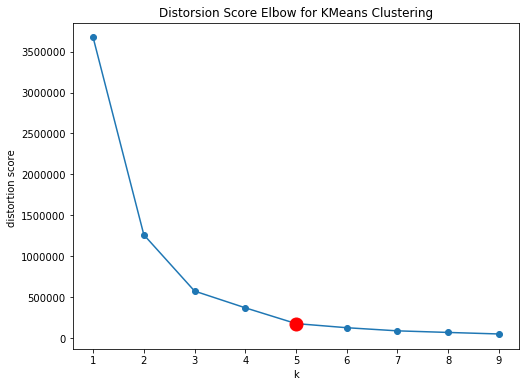

In [33]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(result)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

fig = plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()),marker='o')
plt.plot(5,176419.6486047641,color='red',marker='o',markersize=13)

plt.xlabel("k")
plt.ylabel("distortion score ")
plt.title('Distorsion Score Elbow for KMeans Clustering')

plt.savefig('elbow.png')

plt.show()


### Modeling

In [34]:
# K number
kclusters = 5

# Modeling
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(result)

# Labels
labels = kmeans.labels_

print('Labels for the ten first neighbourhoods:',labels[0:10])

Labels for the ten first neighbourhoods: [2 0 2 2 2 1 0 0 0 0]


### Insights

In [35]:
# Add cluster columns
bcn_clustering = bcn_venues_10
bcn_clustering.insert(1,'Cluster label',labels)

bcn_clustering.head(10)

,Neighbourhood,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baró de Viver,2,Spanish Restaurant,Clothing Store,Plaza,Asian Restaurant,Food,Supermarket,Furniture / Home Store,Metro Station,Bookstore,Mediterranean Restaurant
1,Can Baró,0,Spanish Restaurant,Tapas Restaurant,Grocery Store,Plaza,Chinese Restaurant,Bar,Restaurant,Scenic Lookout,Bookstore,Cambodian Restaurant
2,Can Peguera,2,Grocery Store,Pizza Place,Supermarket,Tapas Restaurant,Breakfast Spot,Seafood Restaurant,Park,Plaza,Sports Club,Café
3,Canyelles,2,Soccer Field,Café,Market,Grocery Store,Mediterranean Restaurant,Skate Park,Metro Station,Tapas Restaurant,Food Court,Plaza
4,Ciutat Meridiana,2,Supermarket,Plaza,Train Station,Grocery Store,Mediterranean Restaurant,Metro Station,Park,Food & Drink Shop,Food,Flower Shop
5,Diagonal Mar i el Front Marítim del Poblenou,1,Mediterranean Restaurant,Restaurant,Café,Hotel,Coffee Shop,Clothing Store,Italian Restaurant,Burger Joint,Pizza Place,Juice Bar
6,Horta,0,Spanish Restaurant,Tapas Restaurant,Park,Bakery,Sandwich Place,Hostel,Mediterranean Restaurant,Supermarket,Pizza Place,Chinese Restaurant
7,Hostafrancs,0,Hotel,Tapas Restaurant,Bar,Gym,Restaurant,Mediterranean Restaurant,Scenic Lookout,Wine Bar,Café,Brewery
8,Montbau,0,Park,Restaurant,Gym,Plaza,Spanish Restaurant,Athletics & Sports,Outdoor Sculpture,Mediterranean Restaurant,Basketball Court,Grocery Store
9,Navas,0,Supermarket,Grocery Store,Spanish Restaurant,Bakery,Café,Farmers Market,Tapas Restaurant,Italian Restaurant,Restaurant,Plaza


In [36]:
bcn_clustering.loc[bcn_clustering['Cluster label']==4]

# df.loc[df['column_name'] == some_value]

,Neighbourhood,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Provençals del Poblenou,4,Pizza Place,Mediterranean Restaurant,Spanish Restaurant,Bakery,Asian Restaurant,Soccer Field,Tapas Restaurant,Hotel,Supermarket,Cocktail Bar
14,Sant Antoni,4,Tapas Restaurant,Hotel,Restaurant,Bar,Café,Coffee Shop,Cocktail Bar,Japanese Restaurant,Spanish Restaurant,Mediterranean Restaurant
19,"Sant Pere, Santa Caterina i la Ribera",4,Hotel,Cocktail Bar,Tapas Restaurant,Café,Mediterranean Restaurant,Breakfast Spot,Wine Bar,Restaurant,Snack Place,Japanese Restaurant
25,Vallcarca i els Penitents,4,Café,Grocery Store,Park,Plaza,Burger Joint,Hotel,Pizza Place,Supermarket,Bakery,Soccer Field
26,"Vallvidrera, el Tibidabo i les Planes",4,Train Station,Hostel,Tourist Information Center,Spanish Restaurant,Restaurant,Soccer Field,Yoga Studio,Fast Food Restaurant,Fabric Shop,Falafel Restaurant
30,el Barri Gòtic,4,Tapas Restaurant,Spanish Restaurant,Hotel,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Bar,Pizza Place,Wine Bar,Plaza
33,el Camp d'en Grassot i Gràcia Nova,4,Tapas Restaurant,Bar,Vegetarian / Vegan Restaurant,Dance Studio,Plaza,Bistro,Indie Movie Theater,Brewery,Spanish Restaurant,Donut Shop
39,el Fort Pienc,4,Restaurant,Coffee Shop,Theater,Spanish Restaurant,Deli / Bodega,Bakery,Café,Bistro,Hostel,Plaza
41,el Parc i la Llacuna del Poblenou,4,Hotel,Mediterranean Restaurant,Spanish Restaurant,Coffee Shop,Café,Restaurant,Bar,Rock Club,Breakfast Spot,Theater
43,el Poblenou,4,Mediterranean Restaurant,Spanish Restaurant,Restaurant,Tapas Restaurant,Italian Restaurant,Café,Breakfast Spot,Cocktail Bar,Bar,Bakery


### Visualization

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude_bcn = 41.38879
longitud_bcn = 2.15899

# create map
map_clusters = folium.Map(location=[latitude_bcn,longitud_bcn],zoom_start=12,tiles='cartodbpositron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(coord['Latitud'], coord['Longitud'], bcn_clustering['Neighbourhood'], bcn_clustering['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis

## Distribution of Clustering in Barcelona neighbourhoods

In [38]:
bcn_clustering.groupby('Cluster label')['Neighbourhood'].count().to_frame()

,Neighbourhood
Cluster label,
0,28
1,6
2,19
3,2
4,18


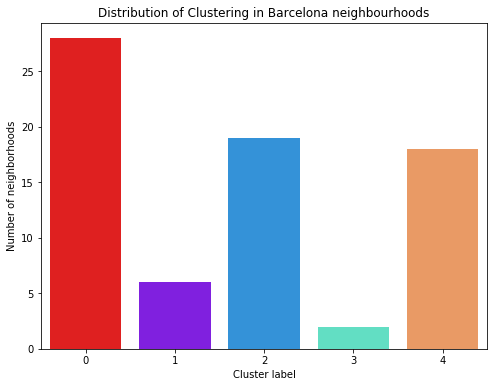

In [39]:
fig = plt.figure(figsize=(8, 6))
a= ['#ff0000','#8000ff','#1996f3','#4df3ce','#ff964f','#b2f396']

sns.barplot(x=bcn_clustering.groupby('Cluster label').count().index,y=bcn_clustering.groupby('Cluster label')['Neighbourhood'].count(),palette=a)

plt.title('Distribution of Clustering in Barcelona neighbourhoods')
plt.ylabel('Number of neighborhoods')

plt.savefig('anali1.png')

plt.show()

## Distribution in rent apartment in our clustering

In [40]:
cluster_rent = result
cluster_rent['Cluster label']=labels

cluster_rent=cluster_rent.groupby('Cluster label')['Aveg_Rent'].mean().reset_index()
cluster_rent.head()

,Cluster label,Aveg_Rent
0,0,790.399371
1,1,1282.906250
2,2,650.916958
3,3,1652.806250
4,4,965.588889


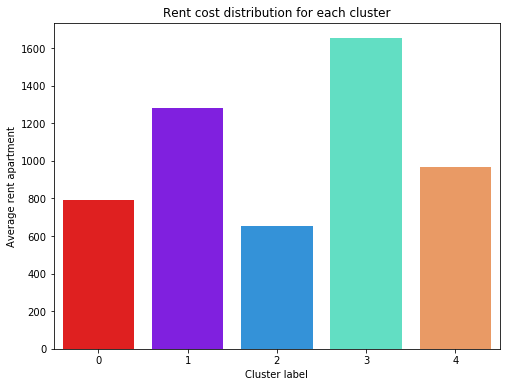

In [41]:
fig = plt.figure(figsize=(8, 6))
a= ['#ff0000','#8000ff','#1996f3','#4df3ce','#ff964f','#b2f396']

sns.barplot(x=cluster_rent['Cluster label'],y=cluster_rent['Aveg_Rent'],palette=a)

plt.title('Rent cost distribution for each cluster')
plt.ylabel('Average rent apartment')

plt.savefig('anali2.png')

plt.show()